In [184]:
#Importing the required libraries
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [185]:
def last_X_summary(df,column,minutes):
    time=str(minutes)+' minutes'
    summs=df.groupby(["match_id","player_id"]).rolling(pd.to_timedelta(time),on='timestamp')[column].sum().reset_index()
    summs.columns=['match_id', 'player_id', 'timestamp', column+'_last_'+str(minutes)+'m']
    df=pd.merge(df,summs,on=["match_id","player_id","timestamp"])
    return df

In [186]:
data=pd.read_csv("pl_events.csv",index_col=0)
#de_events=pd.read_csv("de_events.csv")
#df.drop("Unnamed: 0",axis=1)


D:\Dani\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3526: DtypeWarning: Columns (1,2,3,4,5,6,7,9,10,11,14,18,20,21,22,23,24,25,26,27,29,30,31,42,43,44,45,46,48,49,50,54) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [209]:
df=data.copy()

In [210]:
df['duration']=np.where(df['duration']<0,0,df['duration'])

In [211]:
#df["related_events_0"]=df["related_events"].apply(lambda x: ast.literal_eval(x)[0]  if pd.notnull(x) and x.strip().startswith('[') else [])

In [212]:
df=df[df["timestamp"]!="00:00:00.000"]

In [213]:
df["timestamp"]=pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
df["timestamp"]=np.where(df["period"]==1,df["timestamp"],df["timestamp"]+pd.to_timedelta('45 minutes'))
df["timestamp"]=df["timestamp"].dt.strftime('%H:%M:%S.%f')
df["timestamp"]=pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

In [214]:
df["pass_success"]=np.where((df["type"]=='Pass')&(df["pass_outcome"].isna()),1,np.where(df["type"]=='Pass',0,np.NaN))

In [215]:
df["rand"]=np.random.randint(0,9000000,df.shape[0])

In [216]:
df["rand"]=pd.to_timedelta(df["rand"],unit='ns')

In [217]:
df["timestamp"]=df["timestamp"]+df["rand"]+df["rand"].shift(1)+df["rand"].shift(-2)

In [218]:
df.drop("rand",axis=1,inplace=True)
df=df[df["timestamp"].isna()==False]

In [219]:
df.sort_values(["match_id","player_id","timestamp"],inplace=True)

In [220]:
df["pass_miss"]=np.where(df["pass_success"]==0,1,np.NaN)

In [221]:
df["duel_success"]=np.where((df["duel_outcome"]=="Won")|(df["duel_outcome"]=="Success In Play"),1,np.where(df["type"]=="Duel",0,np.NaN))
df["duel_fail"]=np.where(df["duel_success"]==0,1,np.where(df["type"]=="Duel",0,np.NaN))

In [222]:
df.loc[df["dribble_outcome"]=="Complete","dribble_success"]=1
df.loc[df["dribble_outcome"]=="Incomplete","dribble_success"]=0
df.loc[df["dribble_outcome"]=="Complete","dribble_fail"]=0
df.loc[df["dribble_outcome"]=="Incomplete","dribble_fail"]=1

In [223]:
df["shot_big_chances_missed"]=np.where((df["type"]=='Shot')&(df["shot_statsbomb_xg"]>0.3),1,np.NaN)

In [224]:
df["shot_goal"]=np.where((df["shot_outcome"]=='Goal'),1,np.where(df["type"]=='Shot',0,np.NaN))

In [225]:
##rolling window pandasban
##szelesseg tobb mindenre kiprobalnig


In [226]:
df["dribbled_past"]=np.where(df["type"]=='Dribbled Past',1,np.NaN)

In [227]:
variables=['pass_success',"pass_miss","duel_success",'duel_fail','dribble_success','dribble_fail',"dribbled_past","shot_big_chances_missed","shot_goal"]

In [228]:
req_types=["Pass","Shot","Dribble","Duel"]

In [229]:
new_cols=["minute","event_success","next_event"]
minutes=45
for column in variables:
    df=last_X_summary(df,column,minutes)
    new_cols.append(column+'_last_'+str(minutes)+'m')
df["event_success"]=np.where((df["pass_success"]==1)|(df["duel_success"]==1)|(df["dribble_success"]==1)|(df["shot_goal"]==1),1,0)
pre_model=df[df["type"].isin(req_types)]
pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)
model45_df=pre_model[pre_model["minute"]>20][new_cols].fillna(0)

C:\Users\judod\AppData\Local\Temp\ipykernel_13572\435435935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)


In [230]:
model_cols=["minute","event_success","next_event"]
minutes=30
for column in variables:
    df=last_X_summary(df,column,minutes)
    model_cols.append(column+'_last_'+str(minutes)+'m')
df["event_success"]=np.where((df["pass_success"]==1)|(df["duel_success"]==1)|(df["dribble_success"]==1)|(df["shot_goal"]==1),1,0)
pre_model=df[df["type"].isin(req_types)]
pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)
model30_df=pre_model[pre_model["minute"]>20][model_cols].fillna(0)

C:\Users\judod\AppData\Local\Temp\ipykernel_13572\4169844288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_model["next_event"]=pre_model.groupby(["match_id","player_id"])["event_success"].shift(-1)


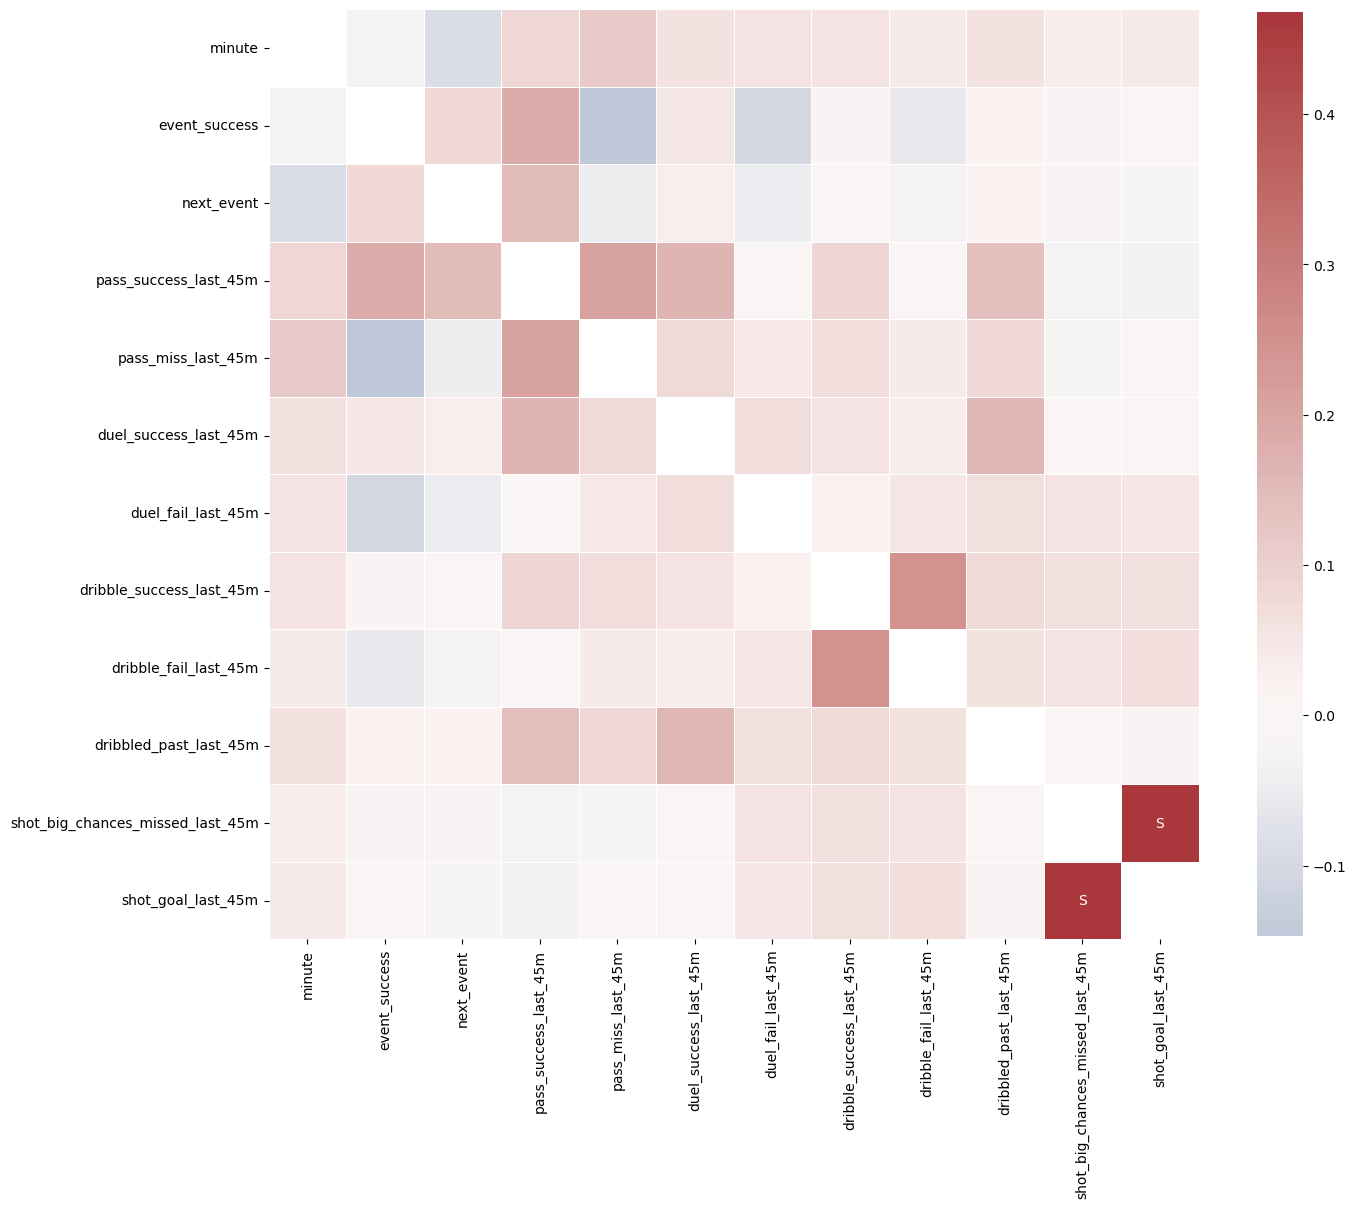

In [231]:
#Feature correlation

# Computes feature correlation
df_corr = model45_df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "H",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "S", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [232]:
target="next_event"

In [233]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [234]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression

In [235]:
def training(train, test, model, encoder, scaler=None, imputer='zero'):
    x_train = train[features]
    y_train = train[target]
    x_test = test[features]
    y_test = test[target]

    pipe = Pipeline(steps=[
        ("encoder", encoder),
        ("scaler", scaler),
        ("Model", model)
    ])
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)
    auc = accuracy_score(y_test, preds)
    f1=f1_score(y_test,preds)
    prec=precision_score(y_test,preds)
    rec=recall_score(y_test,preds)
    
    metric_dict = {'Auc':auc, 'F1':f1,'Prec':prec,'Recall':rec}
    metric_dict=pd.DataFrame([metric_dict])
    
    return(metric_dict)

In [172]:
def evaluate_model(df, model, encoder=None, scaler=None):
    rand_state = 42
    y = df[target]
    X = df[features]
    df = df.fillna(0)
    skf = KFold(n_splits=5)
    metric_df = pd.DataFrame(columns=['Auc', 'F1','Prec','Recall'])

    fold_no = 1
    for train_index,test_index in skf.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        metric_dict = training(train, test, model, encoder, scaler)
        metric_df = pd.concat([metric_df, metric_dict], ignore_index=True)
        fold_no += 1

    means = metric_df.mean()
    metric_df = pd.DataFrame(columns = means.index)
    metric_df.loc[len(metric_df)] = means.values
    return(metric_df)

In [173]:
features=model45_df.drop(["next_event","event_success"],axis=1).columns

In [174]:
model=DecisionTreeClassifier()
evaluate_model(model45_df,model)

,Auc,F1,Prec,Recall
0,0.571,0.674,0.699,0.650


In [175]:
model=LogisticRegression(max_iter=1000)
evaluate_model(model45_df,model)

,Auc,F1,Prec,Recall
0,0.686,0.810,0.689,0.983


In [181]:
features=model30_df.drop(["next_event","event_success"],axis=1).columns

In [171]:
model=LogisticRegression(max_iter=1000)
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.685,0.810,0.687,0.988


In [182]:
model=GaussianNB()
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.665,0.789,0.692,0.918


In [183]:
model=KNeighborsClassifier()
evaluate_model(model30_df,model)

,Auc,F1,Prec,Recall
0,0.643,0.758,0.705,0.820


In [180]:
model45_df.next_event.value_counts()

1.000    219771
0.000    102859
Name: next_event, dtype: int64

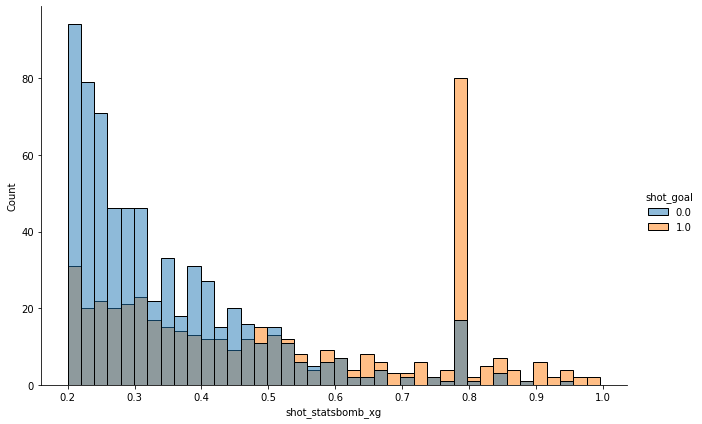

In [90]:
sns.displot(data=df[(df["type"]=='Shot')&(df["shot_statsbomb_xg"]>0.2)],x='shot_statsbomb_xg',hue='shot_goal',height=6,aspect=1.5,bins=40)

In [85]:
df.type.value_counts()

Pass                 368619
Ball Receipt*        340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Substitution           2109
Half Start             1520
Half End               1520
Injury Stoppage        1032
Starting XI             760
Tactical Shift          625
50/50                   559
Shield                  503
Referee Ball-Drop       272
Bad Behaviour           193
Error                   178
Player Off              145
Player On               144
Offside                 109
Own Goal Against         38
Own Goal For             38
Name: type, dtype: int64

In [92]:
df.type.nunique()

31

In [105]:
df.shot_body_part.value_counts()

Right Foot    5367
Left Foot     2916
Head          1608
Other           17
Name: shot_body_part, dtype: int64

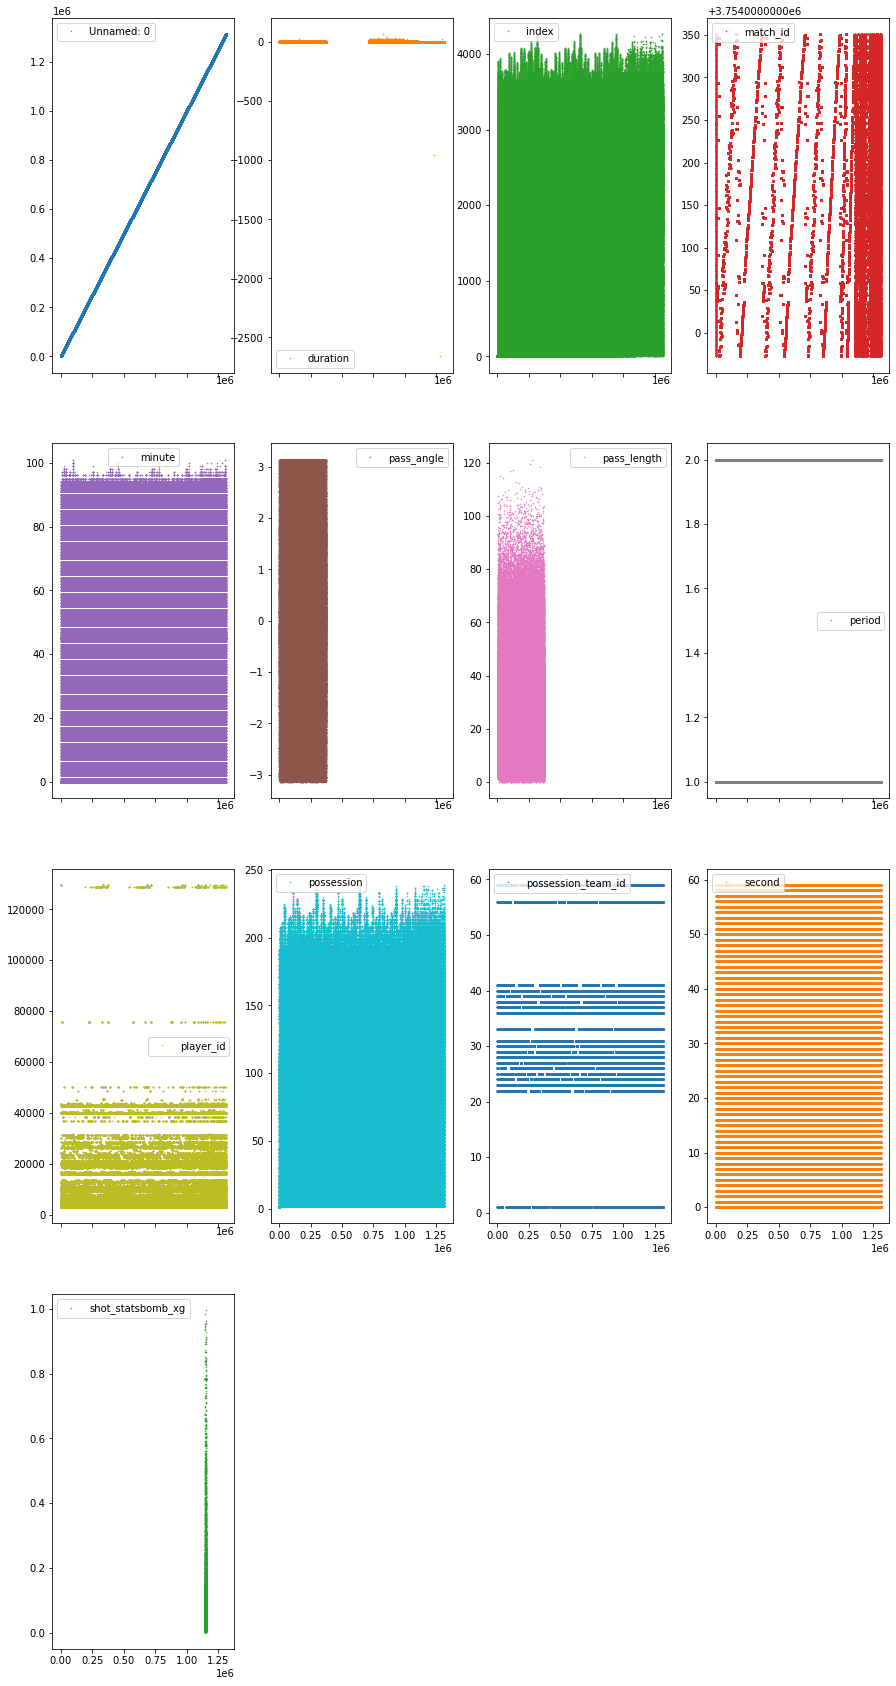

In [4]:
#Overview about the values of the features
df.plot(lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 4),
          figsize=(15, 30),
          markersize=1);

<AxesSubplot:>

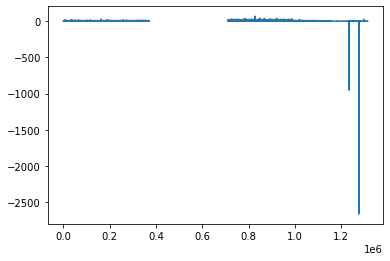

In [5]:
df.duration.plot()

<AxesSubplot:>

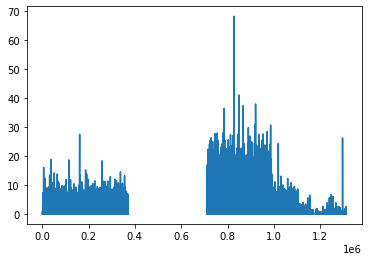

In [7]:
df.duration.plot()

In [176]:
df.type.value_counts()

Pass                368618
Ball Receipt*       340324
Carry               276949
Pressure            115402
Ball Recovery        40943
Duel                 32290
Clearance            21645
Block                14839
Dribble              13721
Goal Keeper          11777
Miscontrol           10786
Dispossessed         10520
Shot                  9908
Foul Committed        9512
Foul Won              9112
Interception          8920
Dribbled Past         8771
Substitution          1928
Injury Stoppage       1030
50/50                  559
Shield                 503
Bad Behaviour          193
Error                  178
Player Off             145
Player On              142
Offside                109
Own Goal Against        38
Name: type, dtype: int64

##### df.describe(exclude='number').T

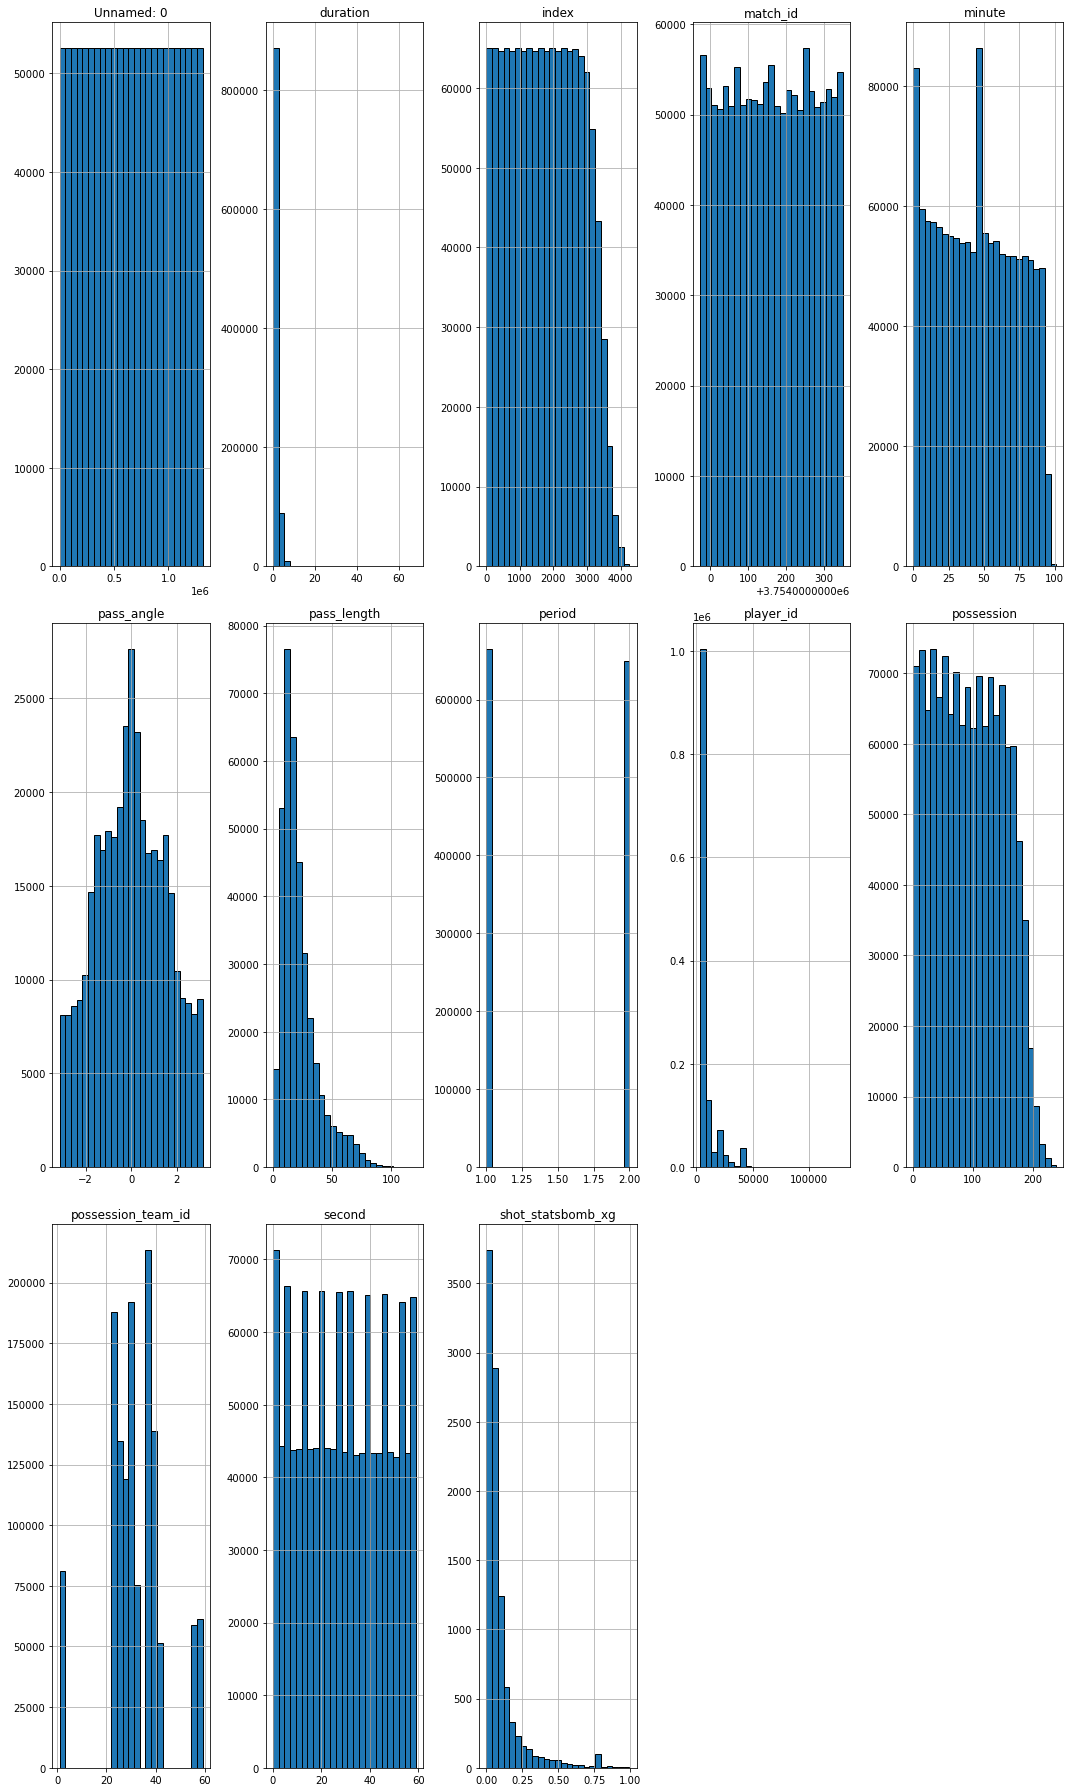

In [10]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

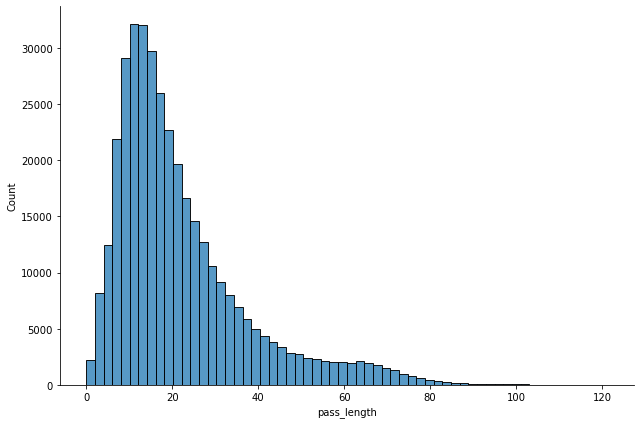

In [102]:
sns.displot(x=df['pass_length'],bins=60,height=6,aspect=1.5)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313783 entries, 0 to 1313782
Data columns (total 54 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   bad_behaviour_card        193 non-null      object 
 1   ball_receipt_outcome      57945 non-null    object 
 2   pass_outcome              86240 non-null    object 
 3   dribble_outcome           13721 non-null    object 
 4   carry_end_location        276949 non-null   object 
 5   carry_end_location.1      276949 non-null   object 
 6   duel_outcome              15445 non-null    object 
 7   duration                  973459 non-null   float64
 8   foul_committed_card       1069 non-null     object 
 9   foul_committed_penalty    91 non-null       object 
 10  goalkeeper_type           11777 non-null    object 
 11  id                        1313783 non-null  object 
 12  index                     1313783 non-null  int64  
 13  interception_outcome      8